# Bengaluru House Price Prediction
#By- Aarush Kumar
#Dated: August 07,2021

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
import sklearn
import xgboost

In [2]:
home = pd.read_csv("/home/aarush100616/Downloads/Projects/Bengaluru House Price Prediction/Bengaluru_House_Data.csv")
home.head()

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00

In [3]:
home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [4]:
round(100*(home.isnull().sum()/len(home.index)),2)

area_type        0.00
availability     0.00
location         0.01
size             0.12
society         41.31
total_sqft       0.00
bath             0.55
balcony          4.57
price            0.00
dtype: float64

In [5]:
home.dropna(inplace =True)

In [6]:
home = home.drop(columns='society')

In [7]:
home.reset_index(drop= True, inplace =True)

In [8]:
home['bhk'] = home['size'].str.split().str[0]
home['bhk'].dropna(inplace = True)
home['bhk'] = home['bhk'].astype('int')

In [9]:
print(home['total_sqft'].iloc[[17]])

17    2100 - 2850
Name: total_sqft, dtype: object


In [10]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [11]:
home.total_sqft = home.total_sqft.apply(convert_sqft_to_num)
home = home[home.total_sqft.notnull()]
home.head(2)

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   

   total_sqft  bath  balcony   price  bhk  
0      1056.0   2.0      1.0   39.07    2  
1      2600.0   5.0      3.0  120.00    4

In [12]:
home = home[~(home.total_sqft/home.bhk<200)]
home.shape

(7478, 9)

In [13]:
cont_ = home.select_dtypes(exclude = 'object')
cat_ = home.select_dtypes(include  = 'object')

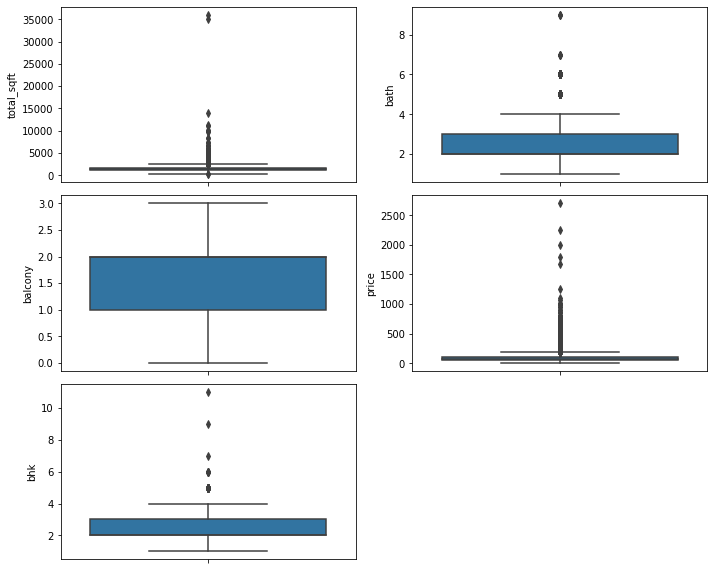

In [14]:
fig = plt.figure(figsize = (10,8))
for index,col in enumerate(cont_):
    plt.subplot(3,2,index+1)
    sns.boxplot(y = cont_.loc[:,col])
fig.tight_layout(pad = 1.0)

In [15]:
home = home.drop(home[home['bath']>6].index)
home = home.drop(home[home['bhk']>7.0].index)

In [16]:
home['price_per_sqft'] = home['price']*100000/home['total_sqft']
home.head()

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
3  Super built-up  Area  Ready To Move                Whitefield      2 BHK   
4            Plot  Area  Ready To Move                Whitefield  4 Bedroom   

   total_sqft  bath  balcony   price  bhk  price_per_sqft  
0      1056.0   2.0      1.0   39.07    2     3699.810606  
1      2600.0   5.0      3.0  120.00    4     4615.384615  
2      1521.0   3.0      1.0   95.00    3     6245.890861  
3      1170.0   2.0      1.0   38.00    2     3247.863248  
4      2785.0   5.0      3.0  295.00    4    10592.459605

In [17]:
home['price_per_sqft'].describe()

count     7471.000000
mean      5853.051952
std       2720.468727
min        371.428571
25%       4277.681409
50%       5315.315315
75%       6693.387739
max      76530.612245
Name: price_per_sqft, dtype: float64

In [18]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
home = remove_pps_outliers(home)
home.shape

(5389, 10)

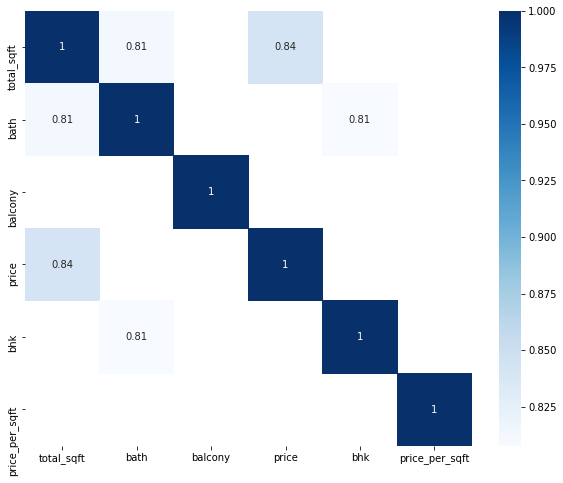

In [19]:
corr = home.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr,mask = corr<0.8 ,annot= True,cmap = 'Blues')

In [20]:
home.drop(columns=['availability','size','area_type'],inplace = True)

In [21]:
home.location = home.location.str.strip()
location_stats = home['location'].value_counts(ascending=False)
location_stats

Whitefield               357
Sarjapur  Road           240
Electronic City          225
Kanakpura Road           157
Yelahanka                141
                        ... 
Nagondanahalli             1
Singapura Village          1
Ramakrishnappa Layout      1
Anwar Layout               1
Suddaguntepalya            1
Name: location, Length: 430, dtype: int64

In [22]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Seegehalli               10
Munnekollal              10
Kannamangala             10
Gubbalala                10
Anandapura               10
                         ..
Nagondanahalli            1
Singapura Village         1
Ramakrishnappa Layout     1
Anwar Layout              1
Suddaguntepalya           1
Name: location, Length: 319, dtype: int64

In [23]:
home.location = home.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
home = home[home.location != 'other']

In [24]:
home = home[home.bath<home.bhk+2]

/home/aarush100616/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


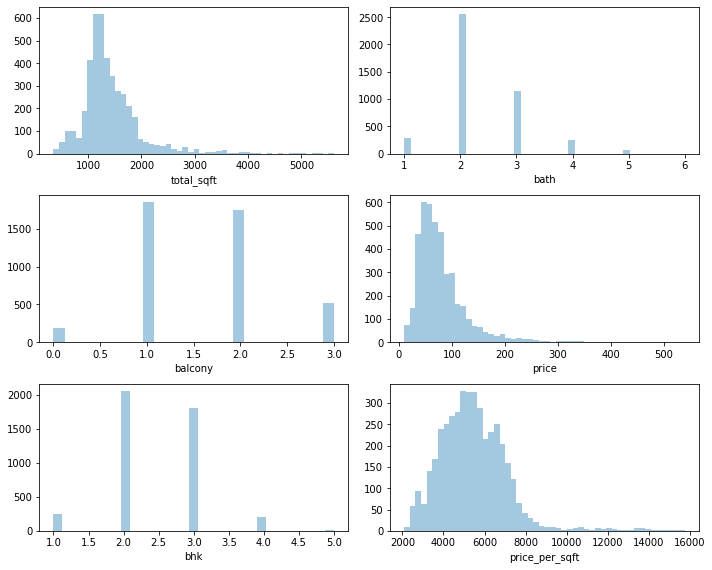

In [25]:
num_ = home.select_dtypes(exclude = 'object')
fig = plt.figure(figsize =(10,8))
for index, col in enumerate(num_):
    plt.subplot(3,2,index+1)
    sns.distplot(num_.loc[:,col],kde = False)
fig.tight_layout(pad = 1.0)

In [26]:
dummies = pd.get_dummies(home.location)
dummies.head(3)

7th Phase JP Nagar  8th Phase JP Nagar  9th Phase JP Nagar  Abbigere  \
8                    0                   0                   0         0   
9                    0                   0                   0         0   
10                   0                   0                   0         0   

    Akshaya Nagar  Ambalipura  Ambedkar Nagar  Ardendale  Attibele  \
8               0           0               0          0         0   
9               0           0               0          0         0   
10              0           0               0          0         0   

    BTM 2nd Stage  ...  Thubarahalli  Tumkur Road  Uttarahalli  Varthur  \
8               0  ...             0            0            0        0   
9               0  ...             0            0            0        0   
10              0  ...             0            0            0        0   

    Vijayanagar  Vittasandra  Whitefield  Yelahanka  Yelahanka New Town  \
8             0            0           0          0                   0   
9             0            0           0          0                   0   
10            0            0           0          0                   0   

    Yeshwanthpur  
8              0  
9              0  
10             0  

[3 rows x 111 columns]

In [27]:
home = pd.concat([home,dummies],axis='columns')
home1 = home.drop('location',axis = 1)
home1 = home1.drop(columns=['balcony','price_per_sqft'])
home1

total_sqft  bath   price  bhk  7th Phase JP Nagar  8th Phase JP Nagar  \
8          550.0   1.0   27.00    1                   0                   0   
9          440.0   1.0   28.00    1                   0                   0   
10         510.0   1.0   25.25    1                   0                   0   
11         510.0   1.0   25.25    1                   0                   0   
44        1080.0   2.0   72.00    2                   1                   0   
...          ...   ...     ...  ...                 ...                 ...   
5384      1169.0   2.0   64.08    2                   0                   0   
5385      2500.0   3.0  138.00    3                   0                   0   
5386      1160.0   2.0   64.08    2                   0                   0   
5387      2503.0   3.0  138.00    3                   0                   0   
5388      1855.0   3.0  135.00    3                   0                   0   

      9th Phase JP Nagar  Abbigere  Akshaya Nagar  Ambalipura  ...  \
8                      0         0              0           0  ...   
9                      0         0              0           0  ...   
10                     0         0              0           0  ...   
11                     0         0              0           0  ...   
44                     0         0              0           0  ...   
...                  ...       ...            ...         ...  ...   
5384                   0         0              0           0  ...   
5385                   0         0              0           0  ...   
5386                   0         0              0           0  ...   
5387                   0         0              0           0  ...   
5388                   0         0              0           0  ...   

      Thubarahalli  Tumkur Road  Uttarahalli  Varthur  Vijayanagar  \
8                0            0            0        0            0   
9                0            0            0        0            0   
10               0            0            0        0            0   
11               0            0            0        0            0   
44               0            0            0        0            0   
...            ...          ...          ...      ...          ...   
5384             0            0            0        0            0   
5385             0            0            0        0            0   
5386             0            0            0        0            0   
5387             0            0            0        0            0   
5388             0            0            0        0            0   

      Vittasandra  Whitefield  Yelahanka  Yelahanka New Town  Yeshwanthpur  
8               0           0          0                   0             0  
9               0           0          0                   0             0  
10              0           0          0                   0             0  
11              0           0          0                   0             0  
44              0           0          0                   0             0  
...           ...         ...        ...                 ...           ...  
5384            0           0          0                   0             1  
5385            0           0          0                   0             1  
5386            0           0          0                   0             1  
5387            0           0          0                   0             1  
5388            0           0          0                   0             1  

[4303 rows x 115 columns]

In [28]:
home1.reset_index(drop = True)

total_sqft  bath   price  bhk  7th Phase JP Nagar  8th Phase JP Nagar  \
0          550.0   1.0   27.00    1                   0                   0   
1          440.0   1.0   28.00    1                   0                   0   
2          510.0   1.0   25.25    1                   0                   0   
3          510.0   1.0   25.25    1                   0                   0   
4         1080.0   2.0   72.00    2                   1                   0   
...          ...   ...     ...  ...                 ...                 ...   
4298      1169.0   2.0   64.08    2                   0                   0   
4299      2500.0   3.0  138.00    3                   0                   0   
4300      1160.0   2.0   64.08    2                   0                   0   
4301      2503.0   3.0  138.00    3                   0                   0   
4302      1855.0   3.0  135.00    3                   0                   0   

      9th Phase JP Nagar  Abbigere  Akshaya Nagar  Ambalipura  ...  \
0                      0         0              0           0  ...   
1                      0         0              0           0  ...   
2                      0         0              0           0  ...   
3                      0         0              0           0  ...   
4                      0         0              0           0  ...   
...                  ...       ...            ...         ...  ...   
4298                   0         0              0           0  ...   
4299                   0         0              0           0  ...   
4300                   0         0              0           0  ...   
4301                   0         0              0           0  ...   
4302                   0         0              0           0  ...   

      Thubarahalli  Tumkur Road  Uttarahalli  Varthur  Vijayanagar  \
0                0            0            0        0            0   
1                0            0            0        0            0   
2                0            0            0        0            0   
3                0            0            0        0            0   
4                0            0            0        0            0   
...            ...          ...          ...      ...          ...   
4298             0            0            0        0            0   
4299             0            0            0        0            0   
4300             0            0            0        0            0   
4301             0            0            0        0            0   
4302             0            0            0        0            0   

      Vittasandra  Whitefield  Yelahanka  Yelahanka New Town  Yeshwanthpur  
0               0           0          0                   0             0  
1               0           0          0                   0             0  
2               0           0          0                   0             0  
3               0           0          0                   0             0  
4               0           0          0                   0             0  
...           ...         ...        ...                 ...           ...  
4298            0           0          0                   0             1  
4299            0           0          0                   0             1  
4300            0           0          0                   0             1  
4301            0           0          0                   0             1  
4302            0           0          0                   0             1  

[4303 rows x 115 columns]

In [29]:
X = home1.drop('price',axis = 1).values 
y = home1.price.values 

In [30]:
y = y[:,np.newaxis]

In [31]:
sc = preprocessing.StandardScaler()
X1 = sc.fit_transform(X)

In [32]:
Std_x1 = preprocessing.scale(X)

In [33]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.model_selection import cross_validate as CV

In [34]:
cross1 = cross_val_score(lr,Std_x1,y,cv=5,scoring='neg_mean_squared_error')
print(cross1.mean())

-5.969116594881906e+29


In [35]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.3,random_state=10)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(rscore)

0.8994969134530868
